# Homograpy

In [1]:
import cv2
from scipy.stats import truncnorm
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
img_src = cv2.imread('/run/media/luo3300612/我是D盘~ o(*￣▽￣*)ブ/下载/迅雷下载/coco/train2014/COCO_train2014_000000551710.jpg')

In [3]:
img_src.shape

(480, 640, 3)

In [3]:
def wrap_shape(pts,height=480,width=640):
    assert pts.shape == (4,2)
    pts[:,0] = pts[:,0]*width
    pts[:,1] = pts[:,1]*height
    return pts

In [5]:
def apply_and_show(img_src,pts1,pts2,title=True):
    pts1 = wrap_shape(pts1)
    pts2 = wrap_shape(pts2)
    h,status = cv2.findHomography(pts2,pts1)

    img_dst = cv2.warpPerspective(img_src,h,(img_src.shape[1],img_src.shape[0]))
    
    # add mask
    img_mask = np.zeros_like(img_src,dtype=np.uint8)
    img_mask = cv2.fillConvexPoly(img_mask,pts2.astype(np.int32),[200,200,200])
    img_show = cv2.addWeighted(img_src,0.5,img_mask,0.5,0)
    
    if title:
        plt.title('img_src')
    plt.axis('off')
    plt.imshow(img_show[:,:,[2,1,0]])
    
    plt.show()
    if title:
        plt.title('img_dst')
    plt.axis('off')
    plt.imshow(img_dst[:,:,[2,1,0]])
    plt.show()
    

## Test center crop

In [162]:
def center_crop(ratio):
    assert ratio <= 1
    margin = (1-ratio)/2
    pts = np.array([[0,0],[0,ratio],[ratio,ratio],[ratio,0]])
    pts += margin
    return pts

In [120]:
pts1 = np.array([[0,0],[0,1],[1,1],[1,0]])
pts2 = center_crop(0.5)

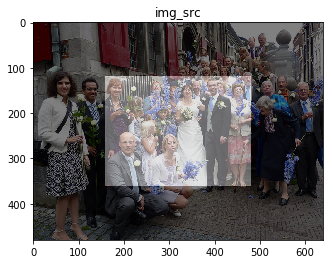

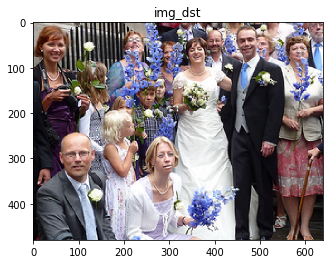

In [121]:
apply_and_show(img_src,pts1,pts2)

## Test Symmetric perspective distort

In [ ]:
def sample_perspective(ratio,allow_artifacts=False,perspective_amplitude_x=0.1,perspective_amplitude_y=0.1):
    margin = (1-ratio)/2
    if not allow_artifacts:
        perspective_amplitude_x = min(perspective_amplitude_x, margin)
        perspective_amplitude_y = min(perspective_amplitude_y, margin)
    
    perspective_displacement = truncnorm.rvs(-perspective_amplitude_y,perspective_amplitude_y)
    h_dislacement_left,h_dislacement_right = truncnorm.rvs(-perspective_amplitude_x,perspective_amplitude_x,size=2).tolist()
    pts = np.array([[h_dislacement_left,perspective_displacement],
                   [h_dislacement_left,-perspective_displacement],
                   [h_dislacement_right,perspective_displacement],
                   [h_dislacement_right,-perspective_displacement]])
    return pts

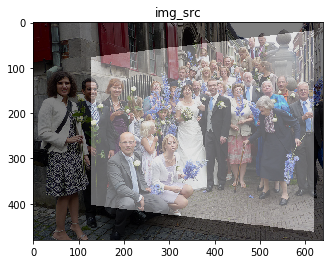

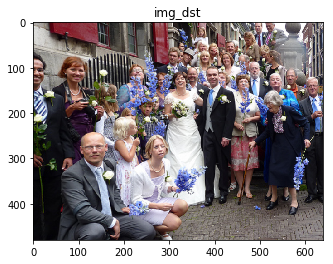

In [161]:
ratio = 0.8
pts1 = np.array([[0,0],[0,1],[1,1],[1,0]])
pts2 = center_crop(ratio)
pts3 = sample_perspective(ratio)

apply_and_show(img_src,pts1,pts2+pts3)


## Test scaling

In [223]:
def sample_scaling(pts=None,scaling_amplitude=0.1,allow_artifacts=False,max_sample=5):
    if pts is None:
        pts = np.array([[0,0],[0,1],[1,1],[1,0]])
    center = pts.mean(axis=0)
    
    count = 0
    while count < max_sample:
        ratio = truncnorm.rvs(-scaling_amplitude,scaling_amplitude) + 1
        pts2 = (pts-center)*ratio + center
        if not allow_artifacts:
            if (pts2>1).any() or (pts2<0).any():
                count += 1
                continue
        print(ratio)
        return pts2
    print(f"sample failed for {max_sample} times")
    print("last pts2:",pts2)

    return None
     


0.5849847014615612


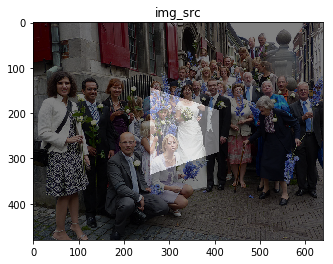

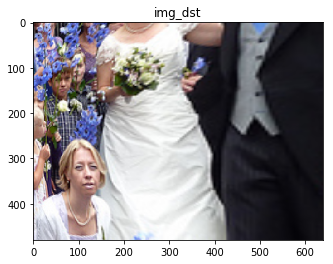

In [233]:
ratio = 0.5
pts1 = np.array([[0,0],[0,1],[1,1],[1,0]])
pts2 = center_crop(ratio) + sample_perspective(ratio)

pts2 = sample_scaling(pts2,0.5)

apply_and_show(img_src,pts1,pts2)

## Test translation

In [300]:
def sample_translation(pts,allow_artifacts=False,translation_overflow=0):
    t_min = pts.min(axis=0)
    t_max = (1-pts).min(axis=0)
    if allow_artifacts:
        t_min += translation_overflow
        t_max += translation_overflow
    x,y = np.random.uniform(-t_min,t_max).tolist()
    pts[:,0] += x
    pts[:,1] += y
    
    return pts
    

[0.25 0.25]
[0.25 0.25]
0.15941545745902103
-0.12462669092377499
[[0.40941546 0.12537331]
 [0.40941546 0.62537331]
 [0.90941546 0.62537331]
 [0.90941546 0.12537331]]


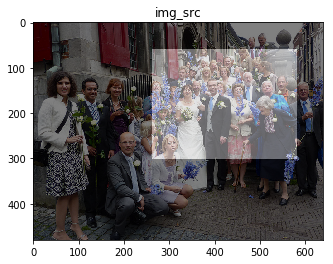

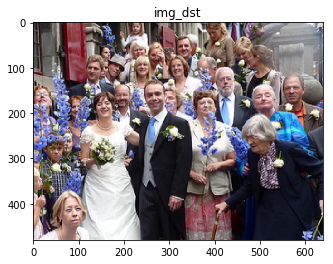

In [324]:
pts1 = np.array([[0,0],[0,1],[1,1],[1,0]])
pts2 = center_crop(0.5)

pts2 = sample_translation(pts2)

apply_and_show(img_src,pts1,pts2)

## test rotation

In [351]:
def sample_rotation(pts=None,max_angle=np.pi/2,allow_artifacts=False,max_sample=5):
    if pts is None:
        pts = np.array([[0,0],[0,1],[1,1],[1,0]])
    center = pts.mean(axis=0)
    pts = pts - center
    count = 0
    while count < max_sample:
        angle = np.random.uniform(-max_angle,max_angle)
        M = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])
        pts2 = pts.dot(M)+center
        print(angle)
        if not allow_artifacts:
            if (pts2>1).any() or (pts2<0).any():
                count += 1
                print('invalid')
                continue
        
        return pts2
    print(f"sample failed for {max_sample} times")
    print("last pts2:",pts2)
    return None

-0.8858803895168902


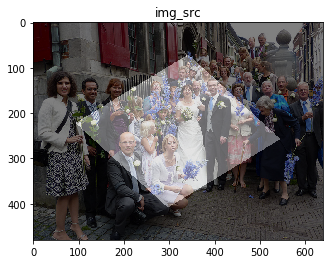

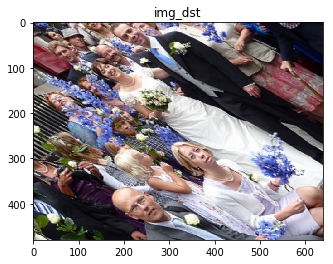

In [367]:
pts1 = np.array([[0,0],[0,1],[1,1],[1,0]])
pts2 = center_crop(0.5)

pts2 = sample_rotation(pts2)

apply_and_show(img_src,pts1,pts2)

## test combination

In [7]:
def sample_homograpy(perspective=True, scaling=True, rotation=True, translation=True,
        max_sample=5, scaling_amplitude=0.1, perspective_amplitude_x=0.1,
        perspective_amplitude_y=0.1, patch_ratio=0.5, max_angle=np.pi/2,
        allow_artifacts=False, translation_overflow=0):
    
    pts = np.array([[0,0],[0,1],[1,1],[1,0]])
    
    # center crop
    assert patch_ratio <= 1
    margin = (1-patch_ratio)/2
    pts2 = np.array([[0,0],[0,patch_ratio],[patch_ratio,patch_ratio],[patch_ratio,0]])
    pts2 += margin
    
    
    # perspective
    if perspective:
        if not allow_artifacts:
            perspective_amplitude_x = min(perspective_amplitude_x, margin)
            perspective_amplitude_y = min(perspective_amplitude_y, margin)

        perspective_displacement = truncnorm.rvs(-perspective_amplitude_y,perspective_amplitude_y)
        h_dislacement_left,h_dislacement_right = truncnorm.rvs(-perspective_amplitude_x,perspective_amplitude_x,size=2).tolist()
        pts2 += np.array([[h_dislacement_left,perspective_displacement],
                       [h_dislacement_left,-perspective_displacement],
                       [h_dislacement_right,perspective_displacement],
                       [h_dislacement_right,-perspective_displacement]])
        
        
    # scaling    
    if scaling:    
        center = pts.mean(axis=0)
        count = 0
        pts2_copy = pts2.copy()
        while count < max_sample:
            ratio = truncnorm.rvs(-scaling_amplitude,scaling_amplitude) + 1
            pts2_copy = (pts2-center)*ratio + center
            if not allow_artifacts:
                if (pts2_copy>1).any() or (pts2_copy<0).any():
                    count += 1
                    continue
            print(ratio)
            pts2 = pts2_copy
            break
        else:
            print(f"sample scaling failed for {max_sample} times")
            print("last pts2:",pts2_copy)
            return None
    
    # rotation
    if rotation:
        center = pts2.mean(axis=0)
        pts2 = pts2 - center
        pts2_copy = pts2.copy()
        count = 0
        while count < 5*max_sample:
            angle = np.random.uniform(-max_angle,max_angle)
            M = np.array([[np.cos(angle),-np.sin(angle)],[np.sin(angle),np.cos(angle)]])
            pts2_copy = pts2.dot(M)+center
            print(angle)
            if not allow_artifacts:
                if (pts2_copy>1).any() or (pts2_copy<0).any():
                    count += 1
                    print('invalid rotation')
                    continue

            pts2 = pts2_copy
            break
        
        else:
            print(f"sample failed for {5*max_sample} times")
            print("last pts2:",pts2_copy)
            return None
        
        
    # translation
    if translation:
        t_min = pts2.min(axis=0)
        t_max = (1-pts2).min(axis=0)
        if allow_artifacts:
            t_min += translation_overflow
            t_max += translation_overflow
        x,y = np.random.uniform(-t_min,t_max).tolist()
        pts2[:,0] += x
        pts2[:,1] += y
    
    return pts2

0.9005249292566985
0.2480205591945459


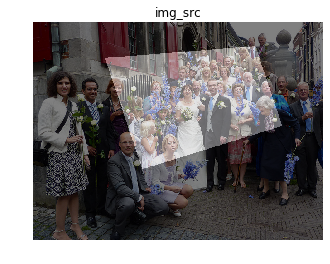

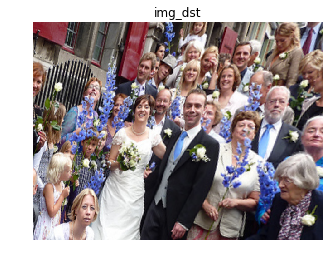

In [16]:
pts = np.array([[0,0],[0,1],[1,1],[1,0]])
pts2 = sample_homograpy()
apply_and_show(img_src,pts,pts2)

In [458]:
heatmap = np.ones((480,640,3),dtype=np.uint8)
background = np.zeros((480,640,3),dtype=np.uint8)
for i in range(1,100):
    pts2 = sample_homograpy()
    pts2 = wrap_shape(pts2)
    heatmap += cv2.fillConvexPoly(background,pts2.astype(np.int32),[1,1,1])

1.0168456530699292
0.04865366683718353
1.0937367107790352
-0.4564120757767638
0.9996681929892752
-0.7857580320903699
0.9877517824572265
-0.4261309786872971
0.9818199057005486
-0.24571798147782897
1.09282987645382
-0.9986304311821479
1.0406296952443728
-1.4072711308777992
0.9519117931495862
0.12145503884606357
0.9986592385804377
-1.3964979945372304
1.076583598391686
1.2275794515281455
0.9885361941819542
1.0715012314403038
0.9561638716507802
0.7954624323553587
0.9945970630180296
0.4987416778919065
1.066666007498085
-0.7337579159225177
0.9161881966915166
-1.0837105701613226
1.0360085427117258
-1.1177653526138707
0.9436360020546462
-1.3818069074573307
0.9251020853499524
0.18098707899925293
0.9152525072360785
1.418950446098734
1.0665846641521735
-1.4193054973163255
1.0304037660397178
-0.004197188191220391
1.0296581476443274
1.5317681556447829
0.9358407696161917
0.13267076724934146
0.9556890495880596
-1.2922955465463142
0.9555607687141775
0.476868385458348
0.9841781960582882
0.20858270034462

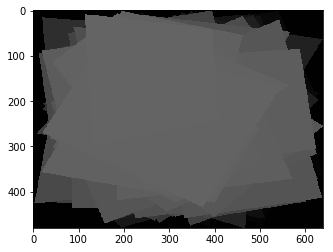

In [459]:
plt.imshow(heatmap)

In [5]:
def sample_homography(shape, perspective=True, scaling=True, rotation=True, translation=True,
                     max_sample=5, scaling_amplitude=0.1, perspective_amplitude_x=0.1,
                     perspective_amplitude_y=0.1, patch_ratio=0.5, max_angle=np.pi / 2,
                     allow_artifacts=False, translation_overflow=0):
    pts = np.array([[0, 0], [0, 1], [1, 1], [1, 0]])

    # center crop
    assert patch_ratio <= 1
    margin = (1 - patch_ratio) / 2
    pts2 = np.array([[0, 0], [0, patch_ratio], [patch_ratio, patch_ratio], [patch_ratio, 0]])
    pts2 += margin

    # perspective
    if perspective:
        if not allow_artifacts:
            perspective_amplitude_x = min(perspective_amplitude_x, margin)
            perspective_amplitude_y = min(perspective_amplitude_y, margin)

        perspective_displacement = truncnorm.rvs(-perspective_amplitude_y, perspective_amplitude_y)
        h_dislacement_left, h_dislacement_right = truncnorm.rvs(-perspective_amplitude_x, perspective_amplitude_x,
                                                                size=2).tolist()
        pts2 += np.array([[h_dislacement_left, perspective_displacement],
                          [h_dislacement_left, -perspective_displacement],
                          [h_dislacement_right, perspective_displacement],
                          [h_dislacement_right, -perspective_displacement]])

    # scaling
    if scaling:
        center = pts.mean(axis=0)
        count = 0
        pts2_copy = pts2.copy()
        while count < max_sample:
            ratio = truncnorm.rvs(-scaling_amplitude, scaling_amplitude) + 1
            pts2_copy = (pts2 - center) * ratio + center
            if not allow_artifacts:
                if (pts2_copy > 1).any() or (pts2_copy < 0).any():
                    count += 1
                    continue
            # print(ratio)
            pts2 = pts2_copy
            break
        else:
            print(f"sample scaling failed for {max_sample} times")
            print("last pts2:", pts2_copy)
            return None

    # rotation
    if rotation:
        center = pts2.mean(axis=0)
        pts2 = pts2 - center
        pts2_copy = pts2.copy()
        count = 0
        while count < 5 * max_sample:
            angle = np.random.uniform(-max_angle, max_angle)
            M = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
            pts2_copy = pts2.dot(M) + center
            # print(angle)
            if not allow_artifacts:
                if (pts2_copy > 1).any() or (pts2_copy < 0).any():
                    count += 1
                    print('invalid rotation')
                    continue

            pts2 = pts2_copy
            break

        else:
            print(f"sample failed for {5 * max_sample} times")
            print("last pts2:", pts2_copy)
            return None

    # translation
    if translation:
        t_min = pts2.min(axis=0)
        t_max = (1 - pts2).min(axis=0)
        if allow_artifacts:
            t_min += translation_overflow
            t_max += translation_overflow
        x, y = np.random.uniform(-t_min, t_max).tolist()
        pts2[:, 0] += x
        pts2[:, 1] += y

    pts = wrap_shape(pts, *shape[:2])
    pts2 = wrap_shape(pts2, *shape[:2])
    h, status = cv2.findHomography(pts2, pts)
    return h

invalid rotation


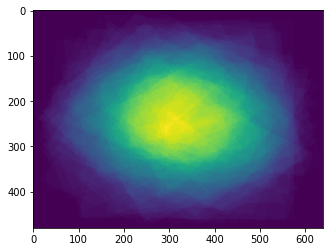

In [114]:
a = -2
b = 2
r = truncnorm.rvs(a, b, size=1000)

(array([ 28.,  65., 104., 136., 167., 151., 134., 114.,  66.,  35.]),
 array([-1.99342196e+00, -1.59439677e+00, -1.19537158e+00, -7.96346386e-01,
        -3.97321196e-01,  1.70399497e-03,  4.00729186e-01,  7.99754376e-01,
         1.19877957e+00,  1.59780476e+00,  1.99682995e+00]),
 <a list of 10 Patch objects>)

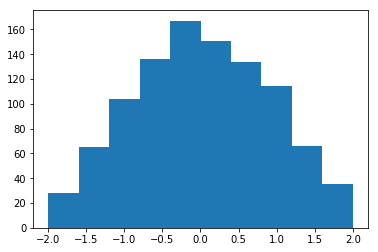

In [115]:
plt.hist(r)

In [425]:
np.nonzero(np.array([[1,1],[1,0]]))

(array([0, 0, 1]), array([0, 1, 0]))

In [426]:
a = np.array(([1,1],[1,0]))

In [428]:
a!=0

array([[ True,  True],
       [ True, False]])

In [12]:
def apply(img_src,pts1,pts2):
    pts1 = wrap_shape(pts1)
    pts2 = wrap_shape(pts2)
    h,status = cv2.findHomography(pts2,pts1)

    img_dst = cv2.warpPerspective(img_src,h,(img_src.shape[1],img_src.shape[0]))
    return img_dst

In [55]:
img_src = cv2.imread('/run/media/luo3300612/我是D盘~ o(*￣▽￣*)ブ/下载/迅雷下载/coco/train2014/COCO_train2014_000000551710.jpg')
img_src = cv2.imread('/run/media/luo3300612/我是D盘~ o(*￣▽￣*)ブ/下载/迅雷下载/coco/train2014/COCO_train2014_000000551868.jpg')
img_src = cv2.imread('/run/media/luo3300612/我是D盘~ o(*￣▽￣*)ブ/下载/迅雷下载/coco/train2014/COCO_train2014_000000551869.jpg')
img_src = cv2.imread('/run/media/luo3300612/我是D盘~ o(*￣▽￣*)ブ/下载/迅雷下载/coco/train2014/COCO_train2014_000000551888.jpg')

img_src = cv2.resize(img_src,(640,480))

In [58]:
pts = np.array([[0,0],[0,1],[1,1],[1,0]])
pts2 = sample_homograpy()
img_dst = apply(img_src,pts,pts2)
cv2.imshow("window1",img_src)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imshow("window1",img_dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

1.0110693560405184
-0.3070608390011762


In [20]:
cv2.imshow("window1",img_dst)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [30]:
count = 1

In [59]:
cv2.imwrite("src" + str(count)+".png",img_src)
cv2.imwrite("dst" + str(count)+".png",img_dst)
count += 1